In [1]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('../data/all-data.csv'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing  import LabelEncoder
le = LabelEncoder()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import missingno as miss
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()

In [3]:
# df = pd.read_csv(io.BytesIO(uploaded['all-data.csv']))
# df = pd.read_csv(uploaded)
df = pd.read_csv("all-data.csv", encoding='latin-1')
df.columns = ["Sentiment", "News Headline"]
df.head()

,Sentiment,News Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


# New Section

In [4]:
df.describe(include = "all")

,Sentiment,News Headline
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


In [5]:
df = df.drop_duplicates()
print(df.head())
print(df.shape)

  Sentiment                                      News Headline
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...
(4840, 2)


In [6]:
df['nr_of_char'] = df['News Headline'].str.len()
df['nr_of_char'] = df['nr_of_char'] / df['nr_of_char'].max()
df[['Sentiment', 'nr_of_char']].pivot(columns = 'Sentiment', values = 'nr_of_char').iplot(kind = 'box')

In [7]:
import re
import spacy
# nlp = spacy.load('en')
nlp = spacy.load("en_core_web_sm")

def normalize(msg):
    
    msg = re.sub('[^A-Za-z]+', ' ', msg) #remove special character and intergers
    doc = nlp(msg)
    res=[]
    for token in doc:
        if(token.is_stop or token.is_punct or token.is_currency or token.is_space or len(token.text) <= 2): #word filteration
            pass
        else:
            res.append(token.lemma_.lower())
    return res

In [8]:
df["News Headline"] = df["News Headline"].apply(normalize)
df.head()

,Sentiment,News Headline,nr_of_char
0,neutral,"[accord, gran, company, plan, production, russ...",0.403175
1,neutral,"[technopoli, plan, develop, stage, area, squar...",0.603175
2,negative,"[international, electronic, industry, company,...",0.723810
3,positive,"[new, production, plant, company, increase, ca...",0.653968
4,positive,"[accord, company, update, strategy, year, basw...",0.644444


In [9]:
rename = {"News Headline": "text", "Sentiment": "labels"}
df.rename(columns = rename, inplace=True)
df.head()

,labels,text,nr_of_char
0,neutral,"[accord, gran, company, plan, production, russ...",0.403175
1,neutral,"[technopoli, plan, develop, stage, area, squar...",0.603175
2,negative,"[international, electronic, industry, company,...",0.723810
3,positive,"[new, production, plant, company, increase, ca...",0.653968
4,positive,"[accord, company, update, strategy, year, basw...",0.644444


In [16]:


df["text"] = df["text"].apply(lambda x : " ".join(x))
df = df[["text", "labels"]]
df["labels"] = le.fit_transform(df["labels"])
df.head()



,text,labels
0,accord gran company plan production russia com...,1
1,technopoli plan develop stage area square mete...,1
2,international electronic industry company elco...,0
3,new production plant company increase capacity...,2
4,accord company update strategy year basware ta...,2


In [17]:
train_x_y = df.sample(frac = 0.75, random_state = 42)
# test_x_y = pd.concat([df, train_x_y]).drop_duplicates(keep=False)
test_x_y = df.drop(train_x_y.index)


print(train_x_y.shape)
print(test_x_y.shape)


(3630, 2)
(1210, 2)


In [ ]:
%pip install simpletransformers

In [18]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model_args = ClassificationArgs()
model_args.train_batch_size = 2
model_args.gradient_accumulation_steps = 8
model_args.learning_rate = 3e-5
model_args.num_train_epochs = 1

model_bert = ClassificationModel("bert", "bert-base-uncased", num_labels=3, args=model_args, use_cuda=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [21]:
model_bert.train_model(train_x_y)

  0%|          | 0/3630 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1815 [00:00<?, ?it/s]

(226, 0.7065279150620696)

In [27]:
p, o = model_bert.predict("Recession is close")
# print(p, o)
test_x_y['text'].values


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

array(['new production plant company increase capacity meet expect increase demand improve use raw material increase production profitability',
       'accord company update strategy year basware target long term net sale growth range operate profit margin net sale',
       'financing aspocomp growth aspocomp aggressively pursue growth strategy increasingly focus technologically demanding hdi print circuit board pcb',
       ...,
       'company say comparable operating profit january june period fall short year correspond performance',
       'helsinki thomson financial shares cargotec fall sharply early afternoon trade cargo handling group post surprise drop april june profit overshadow large number new order receive month',
       'london marketwatch share price end lower london monday rebound bank stock fail offset broad weakness ftse'],
      dtype=object)

In [26]:
import torch
torch.save(model_bert, 'trained')


In [30]:
pred_bert, out_bert = model_bert.predict(list(test_x_y['text'].values))

acc_bert = accuracy_score(test_x_y['labels'].to_numpy(), pred_bert)
f1_bert = f1_score(test_x_y['labels'].to_numpy(), pred_bert, average='micro')

print("Accuracy Score -",acc_bert)
print("F1 Score - ", f1_bert)

  0%|          | 0/1210 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Accuracy Score - 0.7917355371900826
F1 Score -  0.7917355371900826


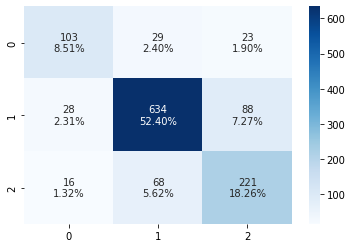

In [31]:
cm = confusion_matrix(pred_bert, test_x_y['labels'].to_numpy())

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(10,5))
sns.regplot(x=pred_bert, y=test_x_y['labels'].to_numpy(),marker="*")
plt.show()